# I - Coordinates, Grids and Fields

HCIPy is a Python library for high-contrast imaging simulations. It uses the concept of a `Field` to simplify syntax and avoid user error. The concept of `Field`s, and their corresponding `Grid`s and `Coords` is an integral part of HCIPy and is used throughout the codebase. This first chapter will focus on ways to create, modify and use `Field`s.

First let's import HCIPy, and a few supporting libraries:

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

A `Grid` defines a set of points in space. There are many functions available for creating a `Field` from scratch. One of these is `make_uniform_grid()`. This function creates a regularly-spaced grid of points in $N$-dimensions in Cartesian space. The following code creates a `Grid` and plots the set of points using Matplotlib.

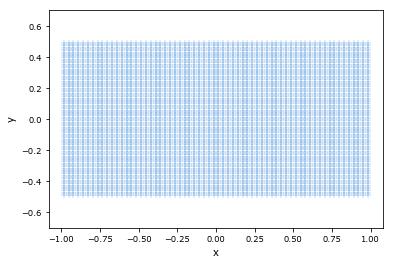

In [2]:
grid = make_uniform_grid([64,64], [2,1])

plt.plot(grid.x, grid.y, '+')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Depending on the coordinate system of the `Grid`, it exposes the arguments `x`, `y`, `z` for Cartesian coordinates, or `r`,`theta` for polar coordinates. Simply said, the `Grid` facilitates the conversion between an index, and a point in $N$-dimensional space.

The coordinate values for each dimension are stored internally in a `Coords` object. There exist some variants of this type of object. Each of these derived classes indicates a structure in the coordinate values. For instance, in the case above:

In [3]:
print('Class of grid:', grid.coords.__class__)
print('Distance between points:', grid.delta)
print('Number of points on each dimension:', grid.dims)
print('Zero-point of the grid:', grid.zero)

Class of grid: <class 'hcipy.field.coordinates.RegularCoords'>
Distance between points: [ 0.03125   0.015625]
Number of points on each dimension: [64 64]
Zero-point of the grid: [-0.984375  -0.4921875]


A `RegularCoords` object doesn't store the values of each point explicitly, but rather calculates those on the fly from three parameters: 1) the distance between points, 2) the number of points on each dimension, 3) the zero point.

Let's use another coordinate system, and differently structured coordinates. We explicitly show how a `Grid` is constructed.

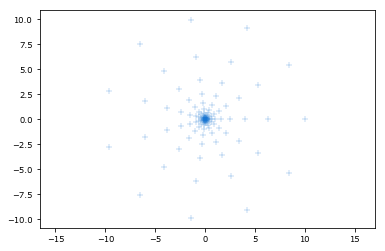

In [4]:
r = np.logspace(-1, 1, 11)
theta = np.linspace(0,2*np.pi, 11, endpoint=False)
coords = SeparatedCoords((r, theta))

polar_grid = PolarGrid(coords)
cart_grid = polar_grid.as_('cartesian')

plt.plot(cart_grid.x, cart_grid.y, '+')
plt.axis('equal')
plt.show()

Note that to plot the points of this polar grid, we have converted the polar grid to a Cartesian grid. Accessing the Cartesian coordinates on a polar grid is not allowed:

In [5]:
try:
    print(polar_grid.x) # Doesn't work
except AttributeError as err:
    print(err)

'PolarGrid' object has no attribute 'x'


Each `Grid` also stores the weight of each point, that is, the interval, area, volume or hyper-volume that a point subtends in its space. They can be used to simplify doing integrations or taking derivatives on a `Grid`. In some cases, the weights can be calculated automatically, for example when the grid has regular or separated coordinates. For other coordinate structures, the weights must be supplied by the user, for example for an `UnstructuredCoords`.

A `Field` is a sampled function on a `Grid`. They can be though of as a physical field, sampled on each point of a `Grid`. We can simply construct a field by:

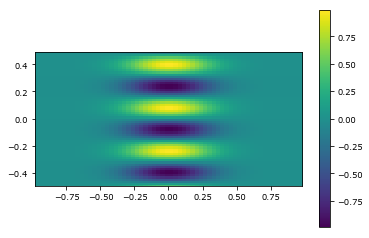

In [6]:
values = np.exp(-(grid.x**2 * 10)) * np.sin(20 * grid.y)
field = Field(values, grid)

imshow_field(field)
plt.colorbar()
plt.show()

A field can be shown by using `imshow_field()`, which acts very similar to the standard Matplotlib `pyplot.imshow()` function. It however does some things in the background. The axes are set to the correct values, according to the `Grid` of the `Field`. Additionally, it supports many other features. For instance, a complex valued field is automatically converted to a two-dimensional colorscale.

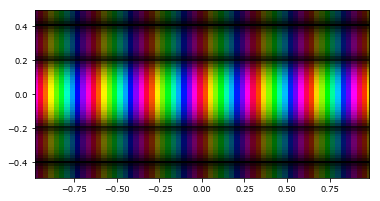

In [7]:
values2 = np.exp(1j * grid.x * 20) * np.sqrt(np.abs(np.sinc(5*grid.y)))
field2 = Field(values2, grid)

imshow_field(field2)
plt.show()

These images can be extremely useful for viewing both phase and amplitude of a complex speckle field at the same time. Additionally, it supports masking out parts of the array during plotting:

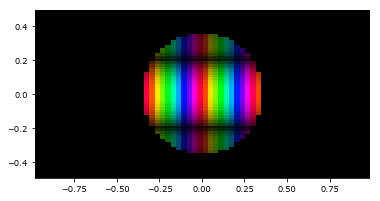

In [8]:
mask = circular_aperture(0.7)(grid)

imshow_field(field2, mask=mask)
plt.show()

The function `circular_aperture(0.7)` here constructs a so-called Field generator. These are functions that take a grid as their sole parameter, and spit out a `Field` on that grid. Essentially, this can be used to calculate any analytical function at a set of points. Some classes and functions in HCIPy take Field generators as arguments, and they are used as output in some cases as well. An important class of Field generators are those generated by aperture functions. These include the above mentioned `circular_aperture`, but also `rectangular_aperture`, `hexagon_aperture`, or even complete telescopes, such as `make_magellan_aperture`:

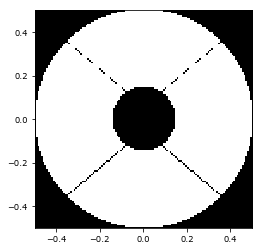

In [9]:
pupil_grid = make_pupil_grid(128)
aperture = make_magellan_aperture(True)

imshow_field(aperture(pupil_grid), cmap='gray')
plt.show()

As the spiders for the Magellan aperture are very small, we have some aliasing effects. This can be avoided using supersampling during the evaluation. HCIPy implements standard functions for these:

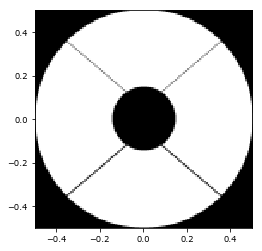

In [10]:
pupil = evaluate_supersampled(aperture, pupil_grid, 8)
imshow_field(pupil, cmap='gray')
plt.show()